In [ ]:
# Prepare environment
import os

if not os.path.isfile("_installed"):
  !pip install spacy dash jupyter-dash pandas==1.2.0 mne[data] gdown yt-dlp webvtt-py librosa > /dev/null
  !python -m spacy download en_core_web_sm
  !apt install p7zip -y > /dev/null
  !echo installed >> _installed

In [ ]:
# Common imports
import sys, os, time

# Module imports
import pandas as pd
import spacy as sp
import numpy as np
import mne
import dash
from dash import html, dcc
from jupyter_dash import JupyterDash
import numpy as np # We might need it.
from dash import dash_table

# NLTK
import nltk
import threading

# We can just download this asynchronously
nltk.download('vader_lexicon')
nltk_thread = threading.Thread(target=lambda: nltk.download("popular", quiet=True))
nltk_thread.setDaemon(True)
nltk_thread.start()

from nltk.corpus import wordnet as wn
from nltk import word_tokenize, pos_tag

# Matplotlib (alternative to dash for simple debugging graphs)
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Download and decrypt MINTS data. I think I put the 3 in the wrong place in the
# password. Oh well.
# Also, it seems like the gdown started randomly failing at some point during
# the week, so I'm temporarily hosting it on a temporary web server. I'm sorry
# in advance for my terrible upload bandwidth.

zip_password = "LetsDoTheMINT3SWarpAgain!"
zipfile_name = "MINTS.zip"
to_download = "MINTS.zip" # Replace with LargeMINTS.zip for the large dataset
if not os.path.exists(zipfile_name):
  !curl https://roadblocktoawesome.com/$to_download --insecure > MINTS.zip
!mkdir -p nlp_data && cd nlp_data && 7z -y x /content/$zipfile_name -p$zip_password


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 0 bytes

Extracting archive: /content/MINTS.zip
ERROR: /content/MINTS.zip
Can not open the file as archive

  0%    
Can't open as archive: 1
Files: 0
Size:       0
Compressed: 0


In [ ]:
# Download biometric modules
!git clone https://github.com/mi3nts/biometricSpeechAnalysis.git
sys.path.append(os.path.abspath("biometricSpeechAnalysis"))

# Import them
# from read_data import *

fatal: destination path 'biometricSpeechAnalysis' already exists and is not an empty directory.


In [ ]:
def read_eeg(vhdr_fname):
    # define list of indicies for non-eeg channels
    misc_list = []
    for i in range(18):
        misc_list.append(i+64)

    # read raw data
    raw = mne.io.read_raw_brainvision(vhdr_fname, misc=misc_list, preload=True,
        verbose=False)
    raw.info['line_freq'] = 500.

    # Set montage
    montage = mne.channels.make_standard_montage('easycap-M1')
    raw.set_montage(montage, verbose=False)

    # Set common average reference
    raw.set_eeg_reference('average', projection=False, verbose=False)

    # create pandas dataframe with eeg data
    df_eeg_data = pd.DataFrame(raw.get_data().transpose(), columns=raw.ch_names)
    
    # Trigger to sync with tobii eye data
    trig_tob = df_eeg_data.loc[df_eeg_data['TRIGGER'] == 3]
    start_tob = trig_tob.index[0]
    df_eeg_data = df_eeg_data.iloc[start_tob:, :]
    df_eeg_data.reset_index(inplace=True)
    
    # create time index - round to integer to match with transcript data
    times = list(range(len(df_eeg_data.index)))
    times = [int(t / 500) for t in times]
    df_eeg_data['Time'] = times
    
    # trigger for data during youtube video
    temp =  df_eeg_data.loc[df_eeg_data['TRIGGER'] == 8888]
    #youtube_start = df_eeg_data.loc[df_eeg_data['TRIGGER'] == 8888].index[0]
    youtube_end = temp.index[len(temp.index) - 1]
    df_eeg_data = df_eeg_data.iloc[:youtube_end + 1, :]
    #print(df_eeg_data_youtube)
    
    df_eeg_data = df_eeg_data.loc[:, ~df_eeg_data.columns.isin(['T7', 'TRIGGER', 'ACC79', 'Packet Counter',
                                                              'ACC77', 'ACC78', 'AUX 2', 'AUX 1', 'index'])]
    
    # sync up time with youtube video
    #df_eeg_data_youtube['Time'] = df_eeg_data_youtube['Time'] - df_eeg_data_youtube.iloc[0]['Time'] + 1
    #df_eeg_data_youtube['Time'] = df_eeg_data_youtube['Time'].astype(int)
    
    return df_eeg_data

In [ ]:
df_eeg_data = read_eeg("./nlp_data/2022_01_14_T04_U002_EEG01/2022_01_14_T04_U002_EEG01.vhdr")

FileNotFoundError: ignored

In [ ]:
yt_wav = "BadTalk.wav"

In [ ]:
!yt-dlp -x --audio-format wav --audio-quality 0 --write-auto-sub -o $yt_wav https://www.youtube.com/watch?v=nGS8_R79vls

[youtube] nGS8_R79vls: Downloading webpage
[youtube] nGS8_R79vls: Downloading android player API JSON
[info] nGS8_R79vls: Downloading 1 format(s): 251
[info] Writing video subtitles to: BadTalk.en.vtt
[download] Destination: BadTalk.en.vtt
[download] 100% of 26.96KiB in 00:00
[download] Destination: BadTalk.webm
[download] 100% of 2.77MiB in 00:00
[ExtractAudio] Destination: BadTalk.wav
Deleting original file BadTalk.webm (pass -k to keep)
[MoveFiles] Moving file "BadTalk.en.vtt" to "BadTalk.wav.en.vtt"


In [ ]:
samplerate = 500

In [ ]:
import webvtt
vtt = webvtt.read(yt_wav + ".en.vtt")

In [ ]:
def ts_to_frameno(ts):
  # Converts a 00:00:00.000 timestamp into a frame number
  hrs, mins, secs = ts.split(":")
  total = int(hrs) * 3600 + int(mins) * 60 + float(secs)
  frameno = int(total * samplerate)
  return frameno

In [ ]:
import re
cap_re = re.compile(r"<(?P<time>\d{2}:\d{2}:\d+\.\d+)><c>(?P<text>[^<]+)</c>")

# Clearly, not the most efficient way of doing it, but it works
frame_to_caption = [0] * len(df_eeg_data)
caption_text = ['']

for caption in vtt:
  print(caption)
  frame_start = ts_to_frameno(caption.start)
  frame_end = ts_to_frameno(caption.end)
  words = []

  for word_start, word_text in cap_re.findall(caption.raw_text):
    word_start = ts_to_frameno(word_start)
    word_text = word_text.strip()
    if not word_text: continue

    words.append((word_start, word_text))
  
  bad_guess = False
  if len(words) == 0 and caption.text.strip():
    words.append((frame_start, caption.text.strip()))
    bad_guess = True

  for i, (word_start, word_text) in enumerate(words):
    if i == len(words) - 1:
      word_end = frame_end
    else:
      word_end = words[i + 1][0] - 1
    
    for i in range(frame_start, min(len(df_eeg_data), word_end + 1)):
      frame_to_caption[i] = len(caption_text) if (frame_to_caption[i] == 0 or not bad_guess) else frame_to_caption[i]
    caption_text.append(word_text)

print(sum(frame_to_caption))
df_eeg_data["Caption"] = frame_to_caption
del frame_to_caption

00:00:08.340 00:00:11.130  \nFrank
00:00:11.130 00:00:11.140  \n 
00:00:11.140 00:00:15.900  \nthat's your real name get off
00:00:15.900 00:00:15.910 that's your real name get off\n 
00:00:15.910 00:00:17.910 that's your real name get off\nthreatening innocent people in danger
00:00:17.910 00:00:17.920 threatening innocent people in danger\n 
00:00:17.920 00:00:19.380 threatening innocent people in danger\nbecause you squeal because you had a
00:00:19.380 00:00:19.390 because you squeal because you had a\n 
00:00:19.390 00:00:21.929 because you squeal because you had a\ncolony we've gone back the hammer that
00:00:21.929 00:00:21.939 colony we've gone back the hammer that\n 
00:00:21.939 00:00:25.410 colony we've gone back the hammer that\nwas for you or the show what does that
00:00:25.410 00:00:25.420 was for you or the show what does that\n 
00:00:25.420 00:00:28.590 was for you or the show what does that\nmean you really have to spell it out for
00:00:28.590 00:00:28.600 mean you 

In [ ]:
#if "Time" in df_eeg_data.keys(): del df_eeg_data["Time"]

In [ ]:
df_eeg_data

,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,...,ExG 4,ECG.,Resp.,PPG,SpO2,HR,GSR,Temp.,Time,Caption
0,-0.007219,-0.002130,0.000159,0.001061,0.003591,-0.000589,0.000366,-0.001565,-0.002582,-0.002542,...,-0.052083,-0.002146,39.018117,16433.000565,100.0,79.0,3652.219534,30.1875,0,0
1,-0.007219,-0.002131,0.000160,0.001058,0.003594,-0.000589,0.000365,-0.001565,-0.002581,-0.002542,...,-0.052083,-0.002148,39.018117,16433.000565,100.0,79.0,3652.219534,30.1875,0,0
2,-0.007219,-0.002130,0.000161,0.001056,0.003593,-0.000587,0.000362,-0.001563,-0.002582,-0.002544,...,-0.052083,-0.002147,39.018117,16433.000565,100.0,79.0,3652.219534,30.1875,0,0
3,-0.007221,-0.002132,0.000159,0.001057,0.003592,-0.000586,0.000364,-0.001561,-0.002581,-0.002542,...,-0.052083,-0.002146,39.018117,16433.000565,100.0,79.0,3652.219534,30.1875,0,0
4,-0.007225,-0.002137,0.000156,0.001054,0.003596,-0.000584,0.000371,-0.001557,-0.002577,-0.002536,...,-0.052083,-0.002143,39.018117,16421.999782,100.0,79.0,3652.219534,30.1875,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111090,-0.007005,-0.001874,0.000007,0.001312,0.003813,-0.000324,0.000734,-0.001273,-0.002184,-0.001799,...,-0.052083,-0.001787,38.559619,16381.999478,100.0,76.0,3655.751467,30.2500,222,0
111091,-0.006997,-0.001871,0.000020,0.001307,0.003813,-0.000349,0.000727,-0.001277,-0.002190,-0.001802,...,-0.052083,-0.001790,38.559619,16381.999478,100.0,76.0,3655.751467,30.2500,222,0
111092,-0.006995,-0.001869,0.000023,0.001317,0.003802,-0.000337,0.000717,-0.001276,-0.002202,-0.001809,...,-0.052083,-0.001797,38.559619,16397.999600,100.0,76.0,3655.751467,30.2500,222,0
111093,-0.007004,-0.001868,0.000010,0.001330,0.003808,-0.000311,0.000725,-0.001279,-0.002203,-0.001813,...,-0.052083,-0.001799,38.559619,16397.999600,100.0,76.0,3655.751467,30.2500,222,0


In [ ]:
fftsize = 512
sampleduration = 1 / samplerate * fftsize

In [ ]:
fakefreq = 20
fakedata = {"T": [np.cos(np.pi * 2 / sampleduration / fftsize * fakefreq * t) for t in range(fftsize * 4)]}

In [ ]:
def do_fft(data, label):
  start = time.time()
  fft = [1 / fftsize * np.fft.fft(data[label][i:i+fftsize]) for i in range(len(data[label]) - fftsize)] + [[0] * fftsize] * fftsize
  # Create tolerance threshold
  threshold = np.max(np.abs(fft)) / 10000
  fft2 = np.where(np.abs(fft) >= threshold, fft, 0)
  data[label + "phase"] = [np.arctan2(np.imag(X), np.real(X)) * 180 / np.pi for X in fft2]
  del fft2
  data[label + "fft"] = fft
  del fft
  print("Performed fft for", label, f"(took {round(time.time() - start, 2)} seconds)")

In [ ]:
#do_fft(fakedata, "T")

In [ ]:
do_fft(df_eeg_data, "FT7")

Performed fft for FT7 (took 20.54 seconds)


In [ ]:
rng = np.arange(-fftsize / 2, fftsize / 2) * sampleduration / fftsize

In [ ]:
def show_fft_data(frame_fft, frame_phase, signal=None, show=True, _start=0):
  graphs = [
    dcc.Graph(
        id="Graph1",
        figure={
            "data": [
                {"x": rng, "y": [np.abs(a) for a in frame_fft[1:]], "type": "line", "name": "magnitude"},
                {"x": rng, "y": [0] * fftsize, "type": "line", "name": "Baseline"},
            ],

            "layout": {
                "title": "FFT",
                "xaxis": {"title": "Frequency (Hz)"},
                "yaxis": {"title": "Magnitude"}
            }
        }
    ),
    dcc.Graph(
        id="Graph2",
        figure={
            "data": [
                {"x": rng, "y": [abs(a) for a in frame_phase[1:]], "type": "line", "name": "phase"},
                {"x": rng, "y": [0] * fftsize, "type": "line", "name": "Baseline"},
            ],

            "layout": {
                "title": "FFT Phase",
                "xaxis": {"title": "Phase"},
                "yaxis": {"title": "Frequency (Hz)"}
            }
        }
    ),
  ]

  if signal is not None:
    sigrng = np.arange(0, fftsize) / fftsize * sampleduration
    graphs.insert(0, dcc.Graph(
        id="Graph3",
        figure={
            "data": [
                {"x": sigrng, "y": signal[_start:_start+fftsize], "type": "line", "name": "phase"},
                {"x": sigrng, "y": [0] * fftsize, "type": "line", "name": "Baseline"},
            ],

            "layout": {
                "title": "Signal",
                "xaxis": {"title": "Time"},
                "yaxis": {"title": "Amplitude"}
            }
        }
    ))
  
  if show:
    # Create app
    app = JupyterDash("Graphs")

    # Realtime bug workaround from 11 hours ago, hot off the presses
    # https://github.com/plotly/dash/issues/1907#issuecomment-1035931483
    del app.config._read_only["requests_pathname_prefix"]
    app.layout = html.Div(children=graphs)

    ###!!!! WARNING! The JupyterDash class is apparently very inefficient the first time it runs.
    ###!!!!          It may take up to ten seconds to load, during which the output will initially
    ###!!!!          appear to be blank. DO NOT FEAR! It will eventually be populated.
    app.run_server(mode="inline", debug=True)
  
  return graphs

In [ ]:
should_show_test_data = False #@param {"type": "boolean"}
print(df_eeg_data.keys())
if should_show_test_data: show_fft_data(df_eeg_data["FT7fft"][0], df_eeg_data["FT7phase"][0], df_eeg_data["Time"])

Index(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7',
       'F8', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1',
       'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'FT9', 'FT10', 'FCz', 'AFz', 'F1',
       'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4',
       'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7',
       'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'CPz', 'POz', 'TP10', 'ExG 1',
       'ExG 2', 'ExG 3', 'ExG 4', 'ECG.', 'Resp.', 'PPG', 'SpO2', 'HR', 'GSR',
       'Temp.', 'Time', 'Caption', 'FT7phase', 'FT7fft'],
      dtype='object')


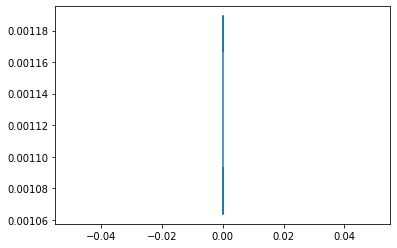

In [ ]:
plt.plot(df_eeg_data[:500]["Time"], df_eeg_data[:500]["FT7"])
plt.show()

In [ ]:
# Normalization, correlation data used for EDA + Data Preprocessing
norm_df_eeg_data = (df_eeg_data - df_eeg_data.mean()) / df_eeg_data.std()
looking_for_indices = [int("you" in caption_text[int(i / samplerate)].split()) for i in range(len(norm_df_eeg_data))]

norm_df_eeg_data["Has_You"] = looking_for_indices
corr_matrix = norm_df_eeg_data.corr()

In [ ]:
# Principle Component Analysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

n = 2
pca = PCA(n_components=n)
print(norm_df_eeg_data.columns[norm_df_eeg_data.isna().any()].tolist())
filtered_eeg_data = norm_df_eeg_data.drop(['FT7fft', 'FT7phase'], axis=1)
pc = pca.fit_transform(filtered_eeg_data)
pc_df = pd.DataFrame(data=pc, columns=[f'PC{i}' for i in range(n)])
var_df = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC':[f'PC{i}' for i in range(n)]})

['FT7fft', 'FT7phase']


# Initial EDA Dashboard
Shows Correlation Heatmap along with PCA = 2 scatterplot. Dropdown allows users to select which features they want to see correlations for.

TODO:
 - Set heatmap color scale to be static (-1, 1)
 - Improve padding between graphs
 - Add some per-feature graphs

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
df_eeg_data["Caption"]

0         0
1         0
2         0
3         0
4         0
         ..
111090    0
111091    0
111092    0
111093    0
111094    0
Name: Caption, Length: 111095, dtype: int64

In [ ]:
#import plotly.express as px
#px.data.tips()

In [ ]:
from dash import Input, Output
import plotly.express as px
import math

'''# Create app
app = JupyterDash("EDA")

# Realtime bug workaround from 11 hours ago, hot off the presses
# https://github.com/plotly/dash/issues/1907#issuecomment-1035931483
del app.config._read_only["requests_pathname_prefix"]

@app.callback(
    Output(component_id='eda_corr', component_property='figure'),
    Input(component_id='eda_feats', component_property='value')
)
def update_corr_fig(input_value):
    cols_idx = [corr_matrix.columns.get_loc(c) for c in input_value]
    filtered_corr_mat = corr_matrix[input_value].iloc[cols_idx]
    corr_fig = px.imshow(filtered_corr_mat, color_continuous_scale='RdBu_r')
    corr_fig.update_layout(transition_duration=500)
    return corr_fig
pca_fig = px.scatter(pc_df, x='PC0', y='PC1')


@app.callback(
    Output(component_id='live-update', component_property='children'),
    Input(component_id='interval1', component_property='n_intervals')
)
def _blah(n):
  # Callback hook
  return update_metrics(n)

app.layout = html.Div(children=[
    html.H1(children='MINTS Biometric Analysis'),
    html.Div(children=[
        html.H2(children='Exploratory Data Analysis'),
        html.Div(children=[
            html.H3(children='Correlations'),
            html.Div(children=[
                html.Div(children=[
                    html.H4(children='Data Features'),
                    dcc.Dropdown(id='eda_feats', options=corr_matrix.columns, value=corr_matrix.columns, multi=True),
                ], style={'display': 'inline-block', 'width': '50%', 'vertical-align': 'top'}),
                html.Div(children=[
                    dcc.Graph(id='eda_corr')  
                ], style={'display': 'inline-block', 'width': '50%', 'vertical-align': 'top'})
            ])
        ], style={'display': 'inline-block', 'width': '50%', 'vertical-align': 'top'}),
        html.Div(children=[
            html.H4(children='Principle Component Analysis'),
            dcc.Graph(id='eda_pca', figure=pca_fig)
        ], style={'display': 'inline-block', 'width': '50%', 'vertical-align': 'top'})
    ]),
    html.H1(children="Live Project Metrics"),
    html.Div(id='live-update'),
    dcc.Interval(id='interval1', interval=500, n_intervals=0)
])

#app.run_server(mode='inline', debug=True, host='localhost', port=1051)'''

'# Create app\napp = JupyterDash("EDA")\n\n# Realtime bug workaround from 11 hours ago, hot off the presses\n# https://github.com/plotly/dash/issues/1907#issuecomment-1035931483\ndel app.config._read_only["requests_pathname_prefix"]\n\n@app.callback(\n    Output(component_id=\'eda_corr\', component_property=\'figure\'),\n    Input(component_id=\'eda_feats\', component_property=\'value\')\n)\ndef update_corr_fig(input_value):\n    cols_idx = [corr_matrix.columns.get_loc(c) for c in input_value]\n    filtered_corr_mat = corr_matrix[input_value].iloc[cols_idx]\n    corr_fig = px.imshow(filtered_corr_mat, color_continuous_scale=\'RdBu_r\')\n    corr_fig.update_layout(transition_duration=500)\n    return corr_fig\npca_fig = px.scatter(pc_df, x=\'PC0\', y=\'PC1\')\n\n\n@app.callback(\n    Output(component_id=\'live-update\', component_property=\'children\'),\n    Input(component_id=\'interval1\', component_property=\'n_intervals\')\n)\ndef _blah(n):\n  # Callback hook\n  return update_metric

In [ ]:
srate = 512

def get_timestamp(i):
  timestamp = str(math.floor(i / srate / 3600) % 60).rjust(2, '0') + ":" + str(math.floor(i / srate / 60) % 60).rjust(2, '0') + ":"
  timestamp += str(math.floor(i / srate) % 60).rjust(2, '0')
  return timestamp

In [ ]:
framewindow = 10
_res = None

sid = SentimentIntensityAnalyzer()
def update_metrics(slider):
  global _res
  i = max(0, slider * srate - 1) # int((time.time() - start) * srate) % len(df_eeg_data["FT7fft"])
  if i > len(df_eeg_data):
    return dash.no_update, "Index " + str(i) + " out of bounds"
  word = caption_text[df_eeg_data["Caption"][i]]
  _words = word.strip().split()
  #print("A")
  scores = sid.polarity_scores(word)
  #print("B")
  timestamp = get_timestamp(i)
  sentiment = [
    html.H2("Sentiment Analysis"),
    html.Div(children=["Word: " + repr(word).replace("'", '"')]),
    html.Div(children=["Timestamp: " + timestamp]),
    html.Div(children=["Sentiment analysis: " + ", ".join("{0}: {1}".format(k, scores[k]) for k in sorted(scores.keys()))])
  ]
  vader_results = {word: sid.polarity_scores(word) for word in _words}
  graph_data = {"neu": [vader_results[word]["neu"] for word in _words],
                "word": _words}

  '''sentiment.append(dcc.Graph(
      figure=px.bar(
          graph_data, x="word", y="neu",
          color=["neu"]
      )
  ))'''
  
  #print("C")
  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html ?
  results = show_fft_data(df_eeg_data["FT7fft"][i], df_eeg_data["FT7phase"][i], df_eeg_data["Time"], show=False, _start=i)
  results = [
    html.Div(style={"display": "flex"}, children=results[:2])
  ] + results[2:]
  results = results + sentiment
  #print(results)
  _res = (time.time(), results)
  return results

In [ ]:
from urllib.request import urlopen, Request
from io import BytesIO
from PIL import Image

user_agent = "MINTSRequester/1.0" #"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.83 Safari/537.36"
bio = BytesIO(urlopen(Request("https://cdn.discordapp.com/attachments/911339282537529419/956940719648563250/EEG_10-10_system.png", headers={"User-Agent": user_agent})).read())

# eeg_img = np.array(Image.new("RGB", (500, 500), color=(255, 255, 255)))
eeg_img = np.array(Image.open(bio).convert('RGB'))

In [ ]:
"""
Usaid's just-added stuff
df_eeg_data = normalized (norm_df_eeg_data)
df_raw_data = df_eeg_data (no normalization)
"""
from jupyter_dash import JupyterDash
from dash import Dash, html, dcc, Input, Output, State
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

external_sheets = ["https://fonts.googleapis.com/icon?family=Material+Icons"]

app = JupyterDash(__name__, external_stylesheets=external_sheets)

@app.callback(
    Output(component_id='eda_corr', component_property='figure'),
    Input(component_id='eda_feats', component_property='value')
)
def update_corr_fig(input_value):
    cols_idx = [corr_matrix.columns.get_loc(c) for c in input_value]
    filtered_corr_mat = corr_matrix[input_value].iloc[cols_idx]
    corr_fig = px.imshow(filtered_corr_mat, color_continuous_scale='RdBu_r', title='Pearson-Coefficient Heatmap', range_color=[-1, 1])
    corr_fig.update_layout(transition_duration=500)
    return corr_fig

def display_time_series(series_feature):
    fig = go.Figure()
    for feat in series_feature:
        fig.add_trace(go.Scatter(x=df_eeg_data[feat].index, y=df_eeg_data[feat].values, name=feat))
    return fig


@app.callback(
    Output('time_series', 'figure'),
    Input('eda_feats', 'value')
)
def update_time_series(series_feature):
  return display_time_series(series_feature)

def eeg_heatmap(slider):
    pos = \
        {
            'FC2': [(288, 215), (315, 242)],
            'Iz': [(243, 499), (269, 526)],
            'T7': [(53, 262), (80, 288)],
            'C1': [(195, 261), (222, 288)],
            'C3': [(147, 261), (174, 288)],
            'F6': [(361, 159), (387, 186)],
            'CPz': [(243, 308), (269, 335)],
            'O1': [(184, 443), (211, 470)],
            'Fpz': [(243, 72), (269, 99)],
            'Ft10': [(469, 188), (496, 215)],
            'FC6': [(378, 209), (405, 236)],
            'CP5': [(107, 314), (134, 341)],
            'Fz': [(243, 166), (270, 193)],
            'AF4': [(301, 119), (328, 146)],
            'P9': [(44, 393), (71, 420)],
            'O2': [(301, 443), (328, 470)],
            'Cz': [(243, 262), (269, 288)],
            'CP6': [(378, 314), (405, 341)],
            'CP2': [(288, 309), (315, 336)],
            'P7': [(89, 374), (116, 401)],
            'T8': [(432, 262), (459, 288)],
            'P8': [(396, 374), (423, 401)],
            'FT9': [(16, 188), (43, 215)],
            'PO3': [(185, 407), (212, 434)],
            'P6': [(360, 365), (387, 392)],
            'F4': [(322, 163), (349, 190)],
            'Fp2': [(301, 82), (327, 109)],
            'FCz': [(243, 214), (269, 241)],
            'T9': [(5, 261), (32, 288)],
            'FC3': [(153, 212), (180, 239)],
            'C6': [(385, 262), (412, 288)],
            'AF8': [(355, 110), (382, 137)],
            'POz': [(243, 403), (270, 430)],
            'F3': [(163, 163), (190, 190)],
            'F10': [(441, 131), (468, 158)],
            'C4': [(338, 261), (365, 288)],
            'Pz': [(243, 357), (269, 384)],
            'P2': [(281, 358), (308, 385)],
            'FT10': [(469, 188), (495, 215)],
            'P5': [(125, 365), (152, 392)],
            'T10': [(480, 262), (507, 288)],
            'P1': [(204, 358), (231, 385)],
            'FC5': [(107, 209), (134, 236)],
            'P10': [(442, 393), (469, 420)],
            'CP3': [(152, 313), (179, 340)],
            'F2': [(281, 166), (308, 193)],
            'F1': [(204, 166), (231, 193)],
            'TP9': [(17, 335), (44, 362)],
            'P3': [(164, 360), (190, 387)],
            'FT7': [(63, 203), (90, 230)],
            'AF7': [(130, 110), (157, 137)],
            'PO4': [(300, 407), (327, 434)],
            'F5': [(124, 159), (151, 186)],
            'PO8': [(354, 416), (381, 443)],
            'TP7': [(63, 321), (90, 348)],
            'P4': [(322, 360), (348, 387)],
            'CP1': [(197, 309), (224, 336)],
            'F9': [(44, 131), (71, 158)],
            'AF3': [(184, 119), (211, 146)],
            'CP4': [(333, 313), (360, 340)],
            'Oz': [(243, 452), (269, 479)],
            'TP10': [(468, 335), (495, 362)],
            'C2': [(290, 261), (317, 288)],
            'F7': [(89, 150), (116, 177)],
            'AFz': [(243, 120), (269, 147)],
            'Fp1': [(185, 82), (211, 109)],
            'Nz': [(243, 24), (269, 51)],
            'PO7': [(131, 416), (158, 443)],
            'F8': [(396, 150), (423, 177)],
            'FT8': [(422, 203), (449, 230)],
            'FC1': [(197, 215), (224, 242)],
            'C5': [(100, 262), (127, 288)],
            'TP8': [(422, 321), (449, 348)],
            'FC4': [(332, 212), (359, 239)],
        }
    fig = px.imshow(eeg_img)
    for feat in df_eeg_data.columns:
        if feat in pos:
            color = 'red'
            weight = abs((df_eeg_data[feat].max() - df_eeg_data.iloc[slider*srate][feat]) / (df_eeg_data[feat].max() - df_eeg_data[feat].min()))
            if df_eeg_data.iloc[slider*srate][feat] < 0:
                color = 'blue'
            fig.add_shape(editable=False, fillcolor=color, type='circle', \
                x0=pos[feat][0][0], y0=pos[feat][0][1], x1=pos[feat][1][0], y1=pos[feat][1][1], \
                    opacity=weight)
    return fig

@app.callback(
    Output('eeg_heatmap', 'figure'),
    Input('time_slider', 'value')
)
def eeg_heatmap_callback(slider):
  return eeg_heatmap(slider)

enable_automatic_play = False
@app.callback(
    Output('other_charts', 'children'),
    Input('time_slider', 'value')
)
def metrics(slider):
  global _res

  _res = "called"
  try:
    return update_metrics(slider)
  except Exception as e:
    _res = e

@app.callback(
    Output("play_button", "children"),
    Input("play_button", "n_clicks")
)
def pbtn(n_clicks):
  global enable_automatic_play
  if n_clicks is None:
    return dash.no_update, ''
  
  if enable_automatic_play:
    enable_automatic_play = False
    return ["play_arrow"]
  else:
    enable_automatic_play = True
    return ["pause"]

minTime = df_eeg_data['Time'].min()
maxTime = df_eeg_data['Time'].max()

@app.callback(
    Output("time_slider", "value"),
    State("time_slider", "value"),
    Input('play_interval', 'n_intervals')
)
def updt(slider, intervals):
  ctx = dash.callback_context
  if not ctx.triggered or not enable_automatic_play: return dash.no_update

  return max(minTime, min(maxTime - 1, slider + 1))

@app.callback(
    Output("timestamp", "children"),
    State("time_slider", "value"),
    Input('play_interval', 'n_intervals')
)
def ts_updt(slider, interval):
  return [str(get_timestamp(slider))]

@app.callback(
    Output("eda_feats", "value"),
    Input("show_all_button", "n_clicks")
)
def proc(n_clicks):
  if n_clicks is None or n_clicks == 0: return dash.no_update, ""
  return corr_matrix.columns

pca_fig = px.scatter(pc_df, x='PC0', y='PC1', title='PCA Scatterplot')

app.layout = html.Div(children=[
    html.H1(children='MINTS Biometric Analysis'),
    html.Div(children=[
        html.H2(children='Exploratory Data Analysis'),
        html.H4(children='Data Features'),
        html.Button("Show All Features", id="show_all_button", n_clicks=0),
        dcc.Dropdown(id='eda_feats', options=corr_matrix.columns, value=corr_matrix.columns[:10], multi=True),
        html.Div(children=[
            html.H3(children='Correlations'),
            html.Div(children=[
                html.Div(children=[
                    dcc.Graph(id='eda_corr')
                ], style={'display': 'inline-block', 'width': '30%', 'verticalAlign': 'top'}),
                html.Div(children=[
                    dcc.Graph(id='time_series', figure=display_time_series(corr_matrix.columns[:10])),
                ], style={'display': 'inline-block', 'width': '70%', 'verticalAlign': 'top'}),
            ]),
        ]),
        html.H2(children='Per-timestep Analysis'),
        html.Div(children=[
          html.H4(children='Timestep', style={"backgroundColor": "inherit"}),
          html.Div(children=[
              html.Div(children=[
                html.Button("play_arrow", id="play_button", className="material-icons"),
                html.P(children=["00:00:00"], id="timestamp", style={"backgroundColor": "inherit"})
              ], style={"float": "left", "width": "3%"}),
              html.Div(children=[dcc.Slider(id='time_slider', value=minTime, min=minTime, max=maxTime)], style={"float": "right", "width": "96%"})
          ])
        ], style={"position": "sticky", "top": "10px", "backgroundColor": "rgba(255, 255, 255, 0.4)", "zIndex": "10000"}),
        html.H4('EEG Heatmap'),
        dcc.Graph(id='eeg_heatmap', figure=eeg_heatmap(minTime)),
        html.Div(children=[
            html.H4(children="Textual Charts"),
            html.Div(id="other_charts", children=update_metrics(minTime))
        ]),
        html.Div(children=[
            html.H4(children='Principle Component Analysis'),
            dcc.Graph(id='eda_pca', figure=pca_fig)
        ])
    ]),
    dcc.Interval(id='play_interval', interval=1000, n_intervals=0)
])

app.run_server(mode="inline", debug=True, port=1051)

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf

In [ ]:
from tqdm import tqdm

In [ ]:
fftwindow = 512
labels = ("FT7", "FT8", "TP7", "TP10")
looking_for = "you"
to_range = len(norm_df_eeg_data) - fftwindow

looking_for_indices = [i for i in range(to_range) if (looking_for in caption_text[int(i / samplerate)].split())]

df_eeg_found = norm_df_eeg_data[norm_df_eeg_data.index.isin(looking_for_indices)]
df_eeg_not_found = norm_df_eeg_data[~norm_df_eeg_data.index.isin(looking_for_indices)]

df_eeg_found.reset_index(inplace=True)
df_eeg_not_found.reset_index(inplace=True)
None

In [ ]:
#df_eeg_found.to_csv('eeg_data_found.csv')
#df_eeg_not_found.to_csv('eeg_data_not_found.csv')

In [ ]:
def convert_inputs1(data):
  tensors = []

  for i in tqdm(range(len(data))):
    tensor = [data[label][i] for label in labels]
    tensors.append(tensor)
  
  return tensors

base_dataset_found = tf.data.Dataset.from_tensor_slices(convert_inputs1(df_eeg_found))
base_dataset_not_found = tf.data.Dataset.from_tensor_slices(convert_inputs1(df_eeg_not_found))

100%|██████████| 94595/94595 [00:03<00:00, 29959.23it/s]


In [ ]:
LSTM_BATCH_LEN = 16 #@param
BATCH_SIZE = 16 #@param

In [ ]:
def transform_data(fft_data):
  return [[tf.abs(fft_data)] * LSTM_BATCH_LEN]

def convert_x_tensors(data):
  return [tf.convert_to_tensor(np.abs(row), dtype=tf.float64) for row in data["FT7fft"]]

x_tensors_found = convert_x_tensors(df_eeg_found)
x_tensors_not_found = convert_x_tensors(df_eeg_not_found)

In [ ]:
fft_dataset_found = tf.data.Dataset.from_tensor_slices(x_tensors_found).map(transform_data)
fft_dataset_not_found = tf.data.Dataset.from_tensor_slices(x_tensors_not_found).map(transform_data)

In [ ]:
#def gen_y_dataset(data):
#  return [[int(looking_for in caption_text[int(i / samplerate)].split())] for i in range(len(data))]

#y_dataset_found = tf.data.Dataset.from_tensor_slices(gen_y_dataset(df_eeg_found))
#y_dataset_not_found = tf.data.Dataset.from_tensor_slices(gen_y_dataset(df_eeg_not_found))

y_dataset_found = tf.data.Dataset.from_tensor_slices([[1]]).repeat(len(df_eeg_found))
y_dataset_not_found = tf.data.Dataset.from_tensor_slices([[0]]).repeat(len(df_eeg_not_found))

In [ ]:
x_dataset_found = tf.data.Dataset.zip((base_dataset_found, fft_dataset_found))
x_dataset_not_found = tf.data.Dataset.zip((base_dataset_not_found, fft_dataset_not_found))

dataset_found = tf.data.Dataset.zip((x_dataset_found, y_dataset_found))
dataset_not_found = tf.data.Dataset.zip((x_dataset_not_found, y_dataset_not_found))

# Split into test and train
train_percent = 0.8
dataset_found_test = dataset_found.skip(int(train_percent * len(dataset_found)))
dataset_not_found_test = dataset_not_found.skip(int(train_percent * len(dataset_not_found)))
dataset_found = dataset_found.take(int(train_percent * len(dataset_found)))
dataset_not_found = dataset_not_found.take(int(train_percent * len(dataset_not_found)))

In [ ]:
joined_dataset = tf.data.Dataset.sample_from_datasets([dataset_found.repeat(), dataset_not_found.repeat()])
joined_dataset_test = dataset_found_test.concatenate(dataset_not_found_test)

dataset = joined_dataset.batch(BATCH_SIZE)
dataset_test = joined_dataset_test.shuffle(len(joined_dataset_test)).batch(BATCH_SIZE)

In [ ]:
input1 = tf.keras.layers.Input(shape=(len(labels),))
input2 = tf.keras.layers.Input(shape=(LSTM_BATCH_LEN, fftsize))

x1 = tf.keras.layers.Dense(48, activation="sigmoid")(input1)
x2 = tf.keras.layers.LSTM(256)(input2)
x2 = tf.keras.layers.Dense(48, activation="sigmoid")(x2)
x = tf.keras.layers.Dense(64)(tf.concat([x1, x2], axis=-1))
x = tf.keras.layers.Dense(16)(x)
x = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs=[input1, input2], outputs=x)

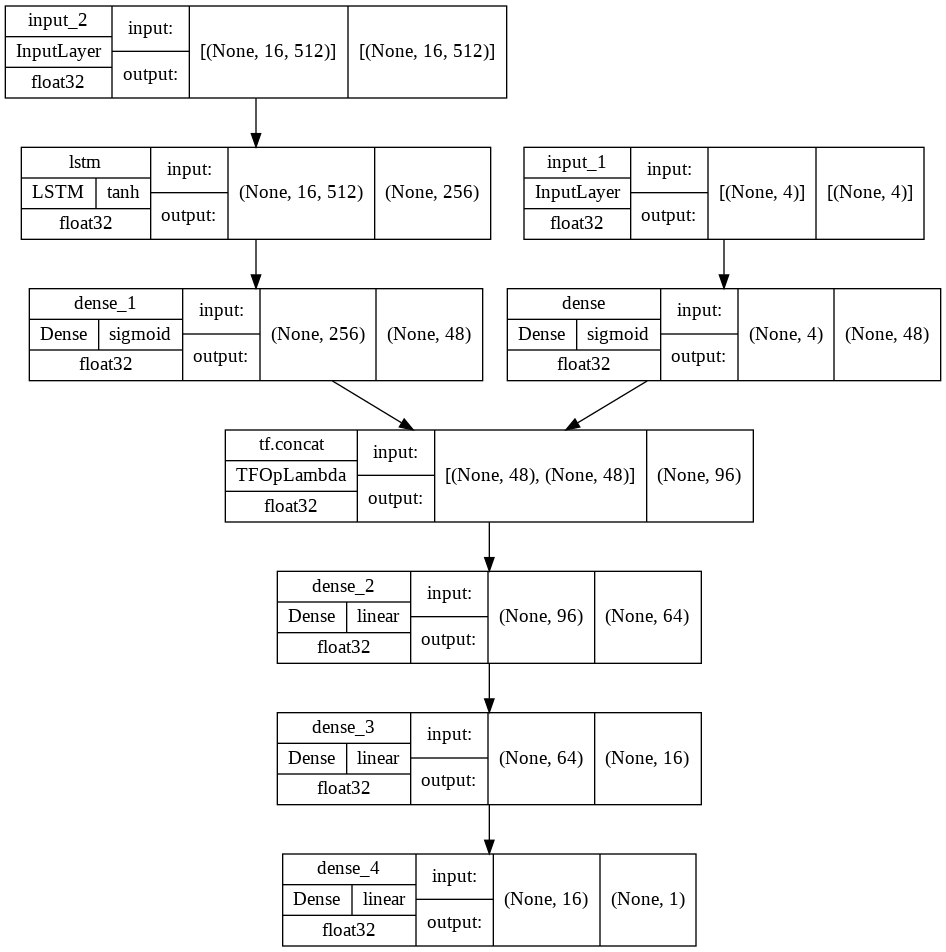

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, dpi=96, show_layer_activations=True)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=["accuracy"])

In [ ]:
history = model.fit(dataset, epochs=5, steps_per_epoch=len(df_eeg_data), validation_data=dataset_test)

Epoch 1/5


ValueError: ignored

In [ ]:
!while 1 do; sleep 1; nvidia-smi; done;

/bin/bash: -c: line 0: syntax error near unexpected token `done'
/bin/bash: -c: line 0: `while 1 do; sleep 1; nvidia-smi; done;'


In [ ]:
## PROBLEM! The data is very uneven (i.e., the "you"s are quite sparse)
## TODO: Ask Usaid + others about evening out the "you"s vs the not "you"s so
##       that we don't have this issue where prediction is unfairly biased
##       towards not "you" regardless of the inputs.

In [ ]:
items = list(iter(dataset.take(8)))

In [ ]:
items[-1][-1]

In [ ]:
# Usaid: Exploratory Data Analysis Stuff I'm trying out
import sys
!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
pd.__version__

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df_eeg_data, minimal=True)
profile.to_file('eda.html')

In [ ]:
df_eeg_data.to_csv('eeg_data.csv')

# MFCCs, extracting features from audio
The current state-of-the-art feature extraction used for speech and speaker recognition is Mel-Frequency Cepstral Coefficients (MFCCs). These were first conceptualized and used in the 80s, and more people continue to find applications where the MFCCs have been helpful and perform quite well. This paper from Sato and Obuchi https://www.jstage.jst.go.jp/article/imt/2/3/2_3_835/_pdf (2007) uses a very simple implementation of MFCCs to get 66.4% accuracy in distinguishing between the emotions (hot anger, neutral, sadness, and happiness). When just looking at the emotions (hot anger, and neutral) the simple algorithm gets 98.75% accuracy. Both of these improve on previous attempts that used Prosodic feataures (pitch, loudness, tempo, rhythm). This shows that MFCCs are a good feature for us to extract if we are looking to gather some emotive responses from the audio to pair with the biometric information. 

\\
While this might be more than enough to go off of, if we are looking to take it a step further, the paper "Recognition of Human Speech Emotion Using Variants of Mel-Frequency Cepstral Coefficients" published in 2018 can help provide some direction for which variations to use. 
https://www.researchgate.net/profile/Lenin-Nc/publication/321755687_Linear_Synchronous_Reluctance_Motor-A_Comprehensive_Review/links/5b18bdd90f7e9b68b424b63e/Linear-Synchronous-Reluctance-Motor-A-Comprehensive-Review.pdf#page=490
## Visualizing Mel Spectrograms

In [ ]:
import librosa
import librosa.display

# Load the yt_wav file into a signal matrix

signal, audio_sample_rate = librosa.load(yt_wav)



(15, 2049)

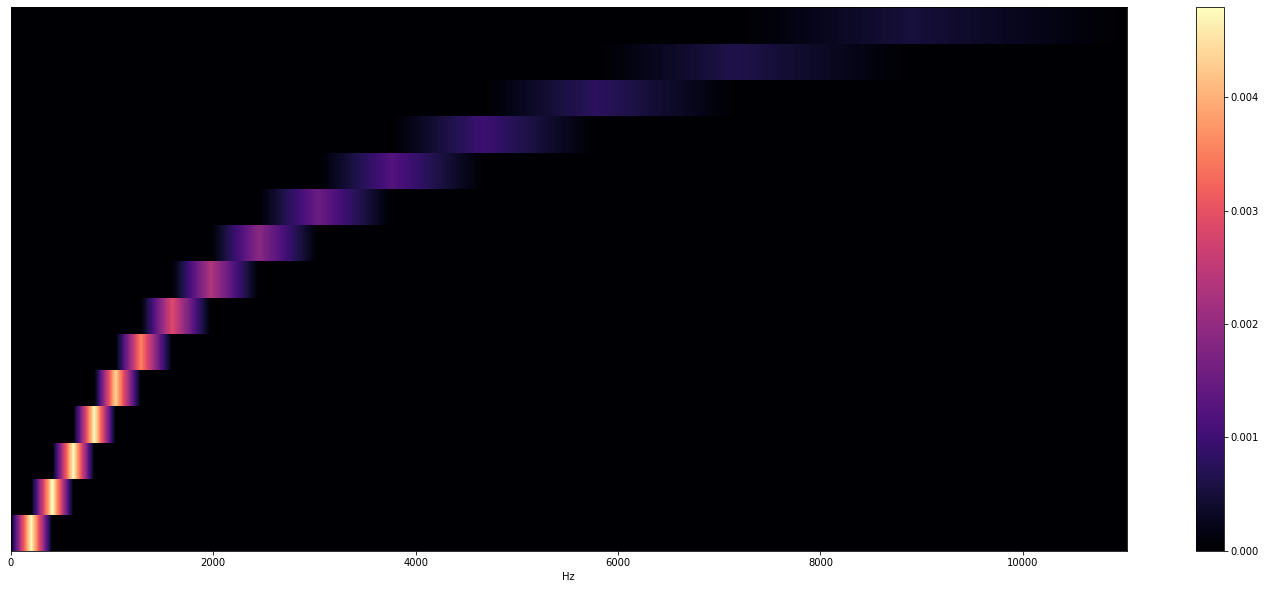

In [ ]:
# get the Mel filter banks. key to getting the spectrogram 
# extract vanilla spectrogram, apply mel filter banks, get the mel spectrogram
# answers the question what is the weight that should be applied to each frequency? i.e. where are the important mel bands

filter_banks = librosa.filters.mel(n_fft=4096, sr=audio_sample_rate, n_mels=15)
plt.figure(figsize=(25, 10))
librosa.display.specshow(filter_banks, sr=audio_sample_rate, x_axis="linear")
plt.colorbar()
plt.show()

# the higher weights indicate where the center of the mel bands are, you can see the 15 mel bands as blocks, and the intensity shows how high the mel peak is

In [ ]:
mel_spectrogram = librosa.feature.melspectrogram(signal, sr=audio_sample_rate, n_fft=4096, hop_length=512, n_mels=15)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

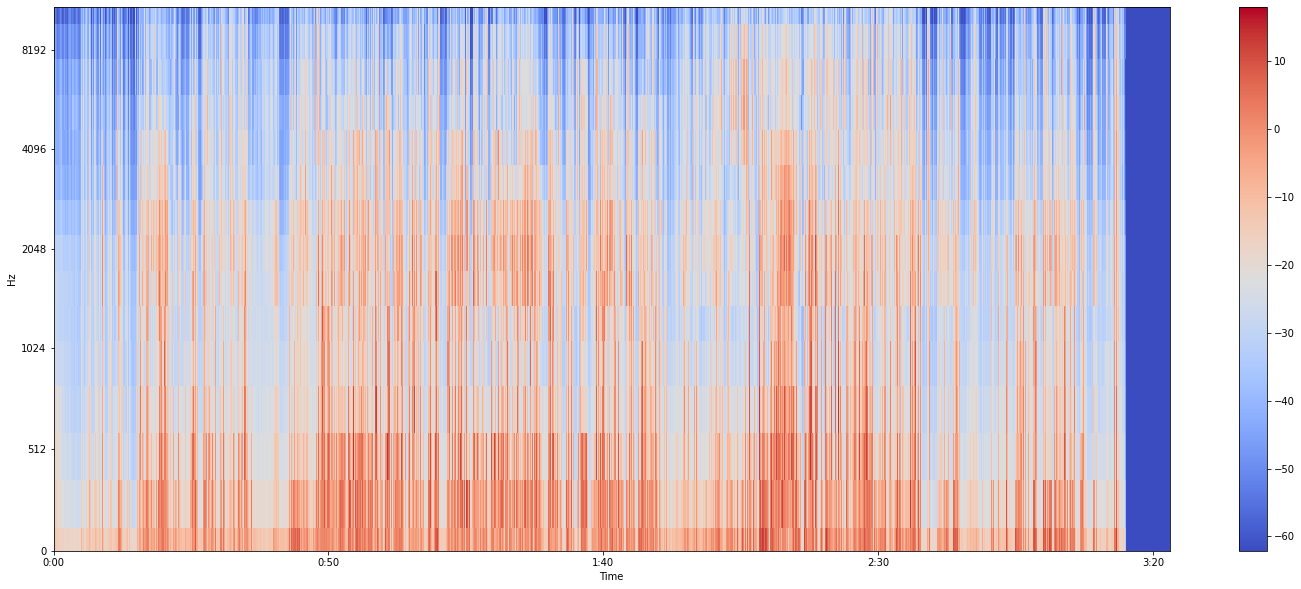

In [ ]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(log_mel_spectrogram, x_axis="time", y_axis="mel", sr=audio_sample_rate)
plt.colorbar()
plt.show()

# Extracting MFCCs from the yt_wav

In [ ]:
# extract the 15 highest MFCCs (arbitrary 15)

mfccs = librosa.feature.mfcc(signal, n_mfcc=15, sr=audio_sample_rate)
mfccs.shape

(15, 8741)

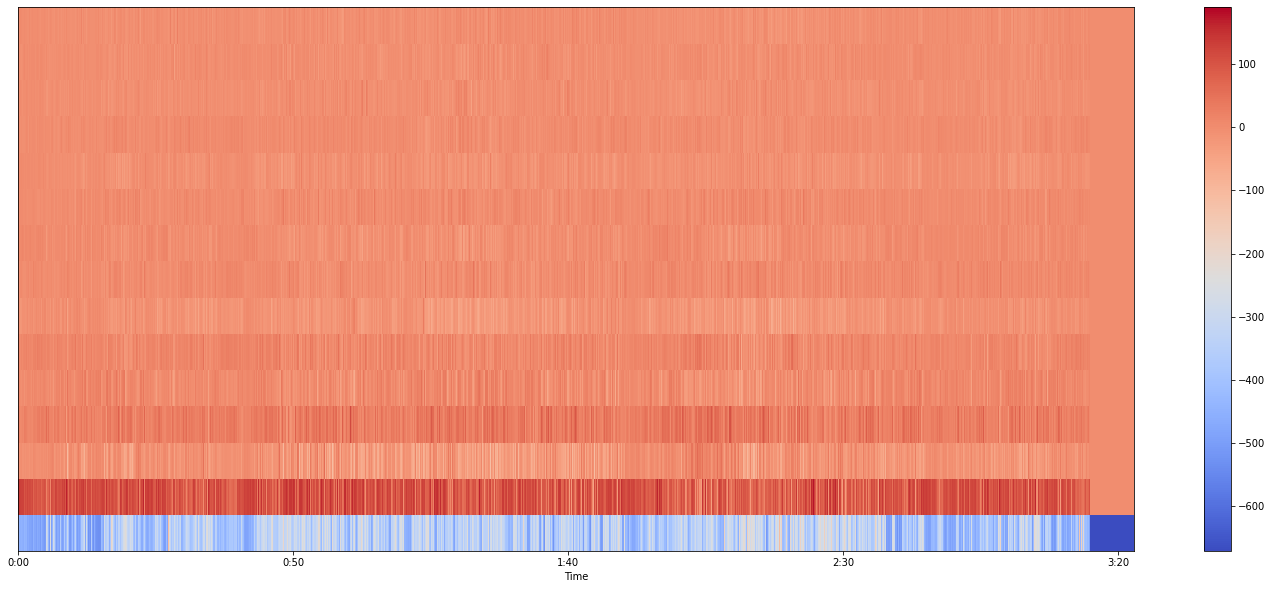

In [ ]:
# visualize the MFCCs, spectrum of a spectrum
plt.figure(figsize=(25, 10))
librosa.display.specshow(mfccs, x_axis="time", sr=audio_sample_rate)
plt.colorbar()
plt.show()

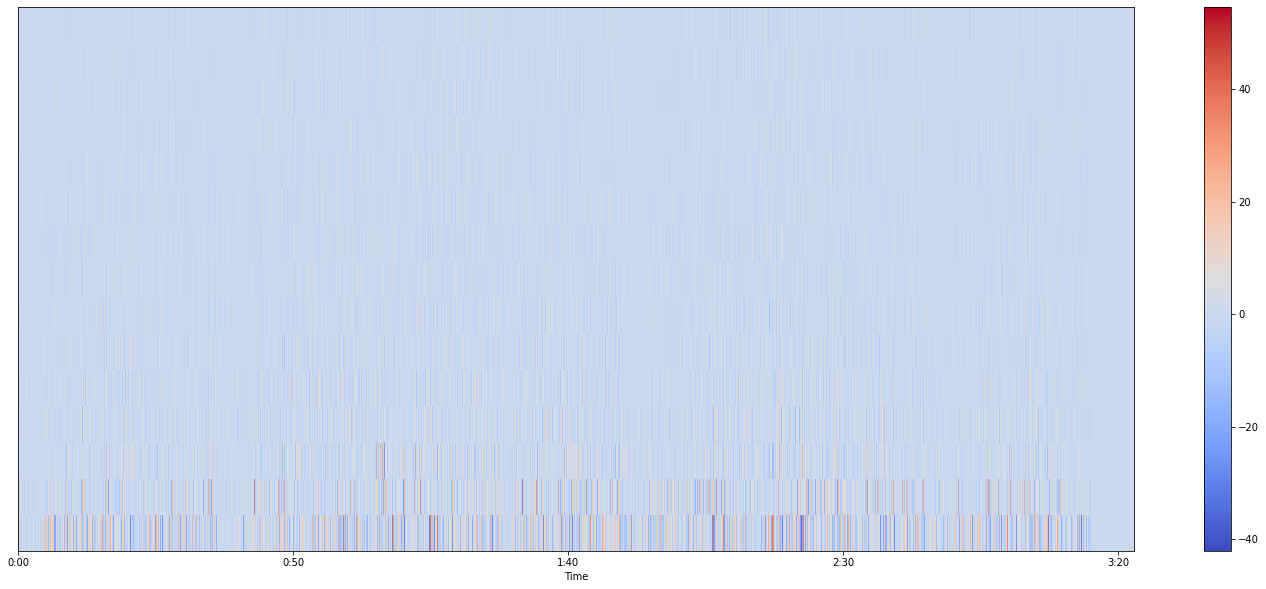

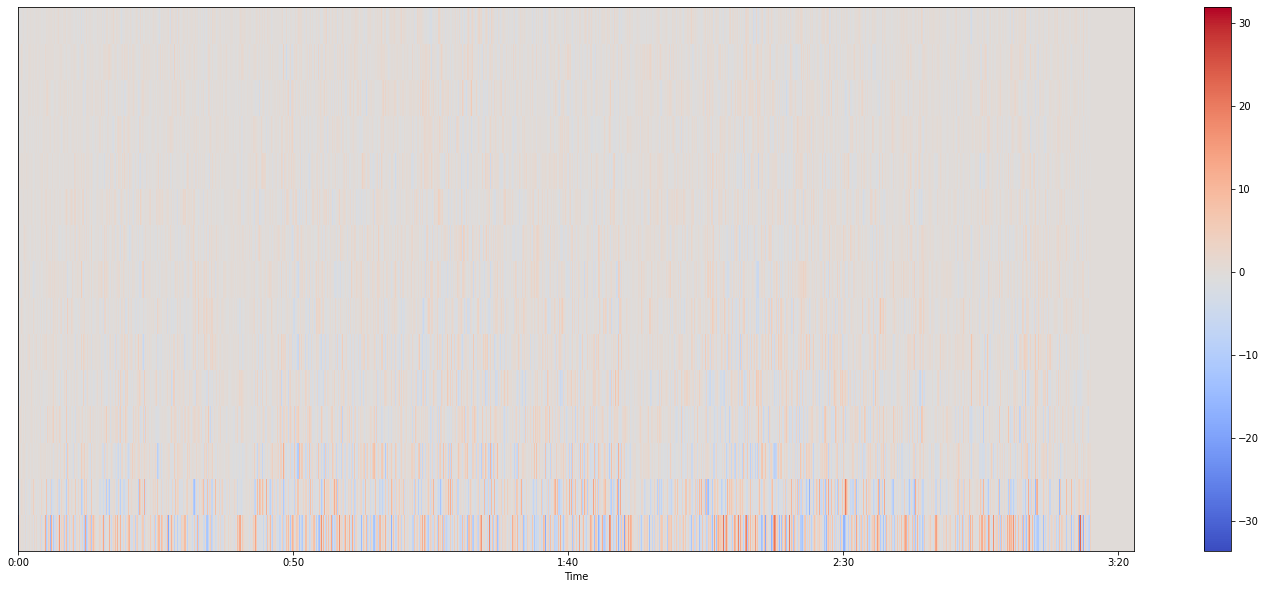

In [ ]:
# calculate delta and delta2 MFCCs (first and second derivatives)
delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

# visualize the derivatives of the MFCCs
plt.figure(figsize=(25, 10))
librosa.display.specshow(delta_mfccs, x_axis="time", sr=audio_sample_rate)
plt.colorbar()
plt.show()

plt.figure(figsize=(25, 10))
librosa.display.specshow(delta2_mfccs, x_axis="time", sr=audio_sample_rate)
plt.colorbar()
plt.show()

In [ ]:
combined_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
combined_mfccs.shape

(45, 8741)